In [1]:
import numpy as np

from hfnet.datasets.hpatches import Hpatches
from hfnet.evaluation.visualize import draw_keypoints
from hfnet.evaluation.loaders import sift_loader, export_loader, fast_loader, harris_loader
from hfnet.evaluation.utils.keypoints import keypoints_warp_2D
from hfnet.evaluation.keypoint_detectors import compute_correctness

from utils import plot_images

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
data_config = {'make_pairs': True, 'shuffle': True}
dataset = Hpatches(**data_config)

In [3]:
all_configs = {
    'sift': {
        'predictor': sift_loader,
    },
    'fast': {
        'predictor': fast_loader,
        'do_nms': True,
        'nms_thresh': 4,
    },
    'harris': {
        'predictor': harris_loader,
        'do_nms': True,
        'nms_thresh': 4,
    },
    'superpoint': {
        'experiment': 'super_point_pytorch/hpatches',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
    },
    'lfnet': {
        'experiment': 'lfnet/hpatches_kpts-500',
        'predictor': export_loader,
    },
    'hfnet': {
        'experiment': 'hfnet-shared_weights-unc_aug-photo_glm-bdd_lrsteps/hpatches',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
    }
}
eval_config = {'num_features': 300}
configs = {c: {**all_configs[c], **eval_config} for c in ['sift', 'superpoint', 'hfnet']}

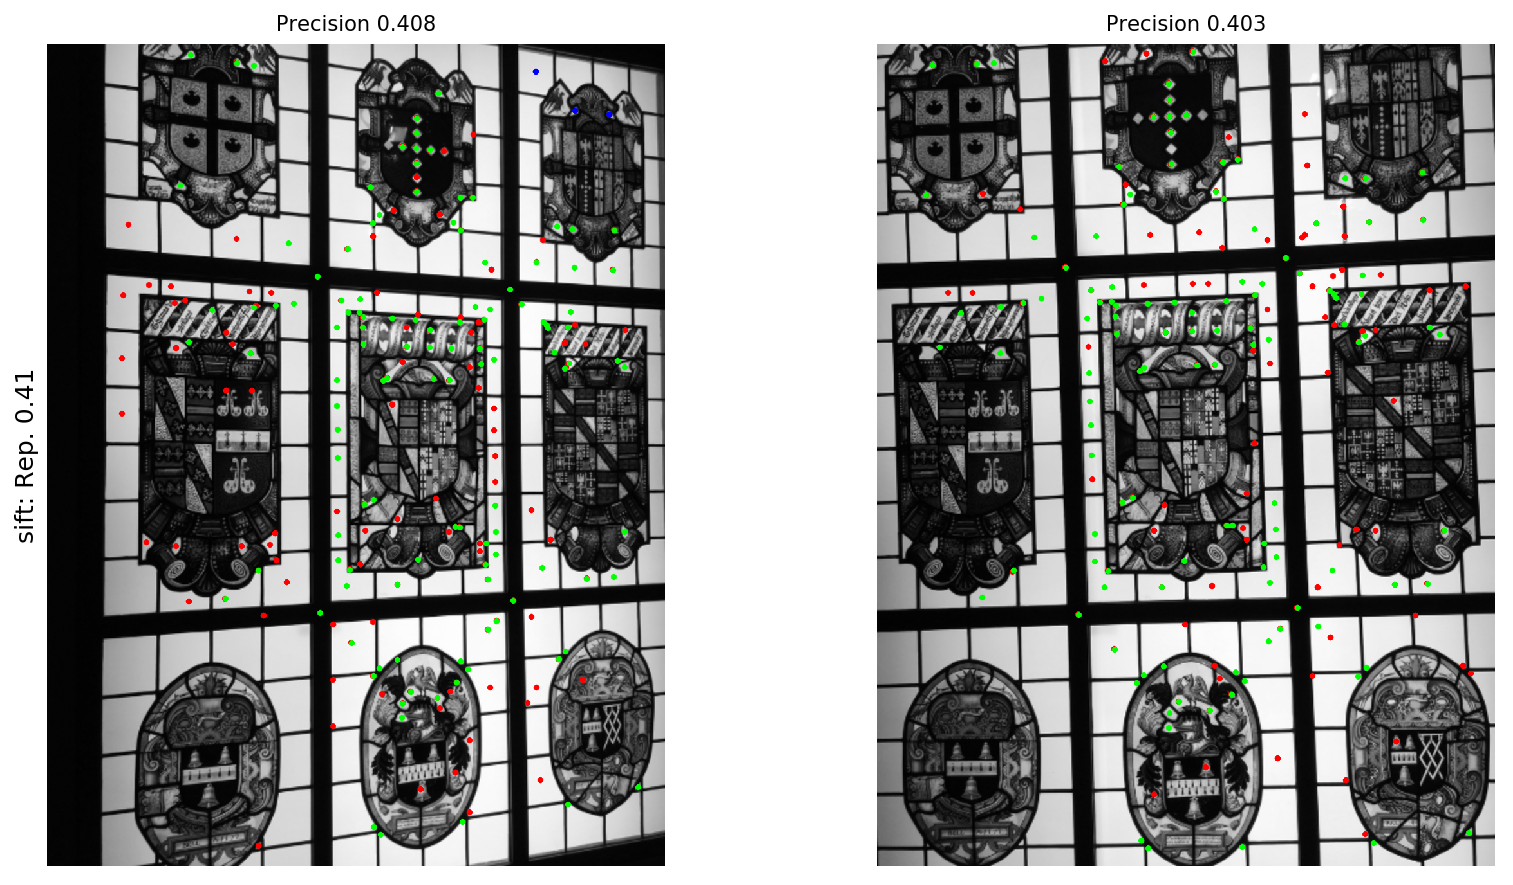

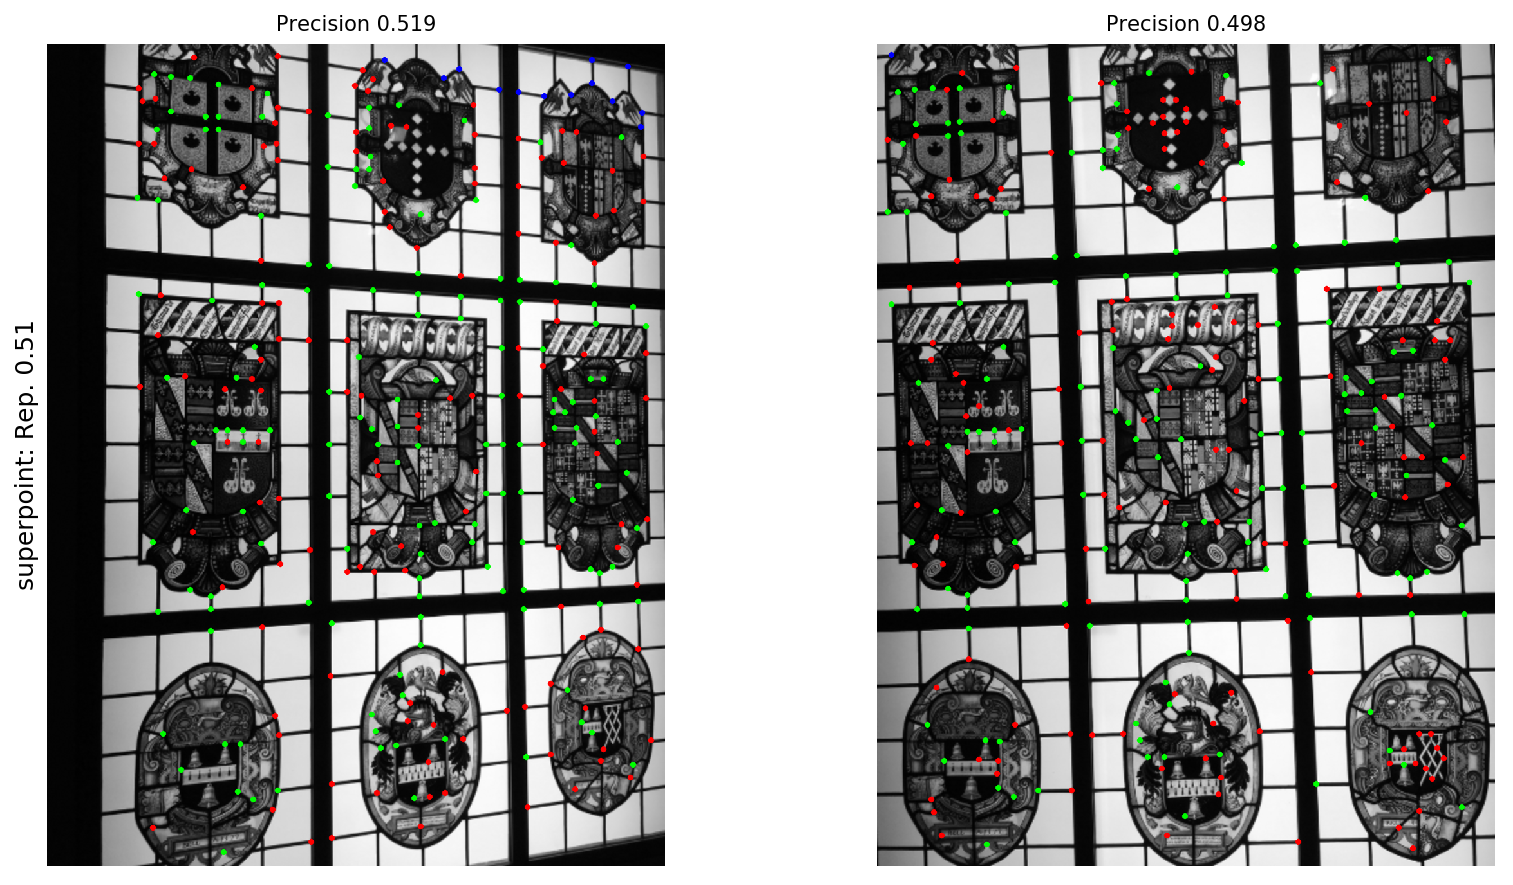

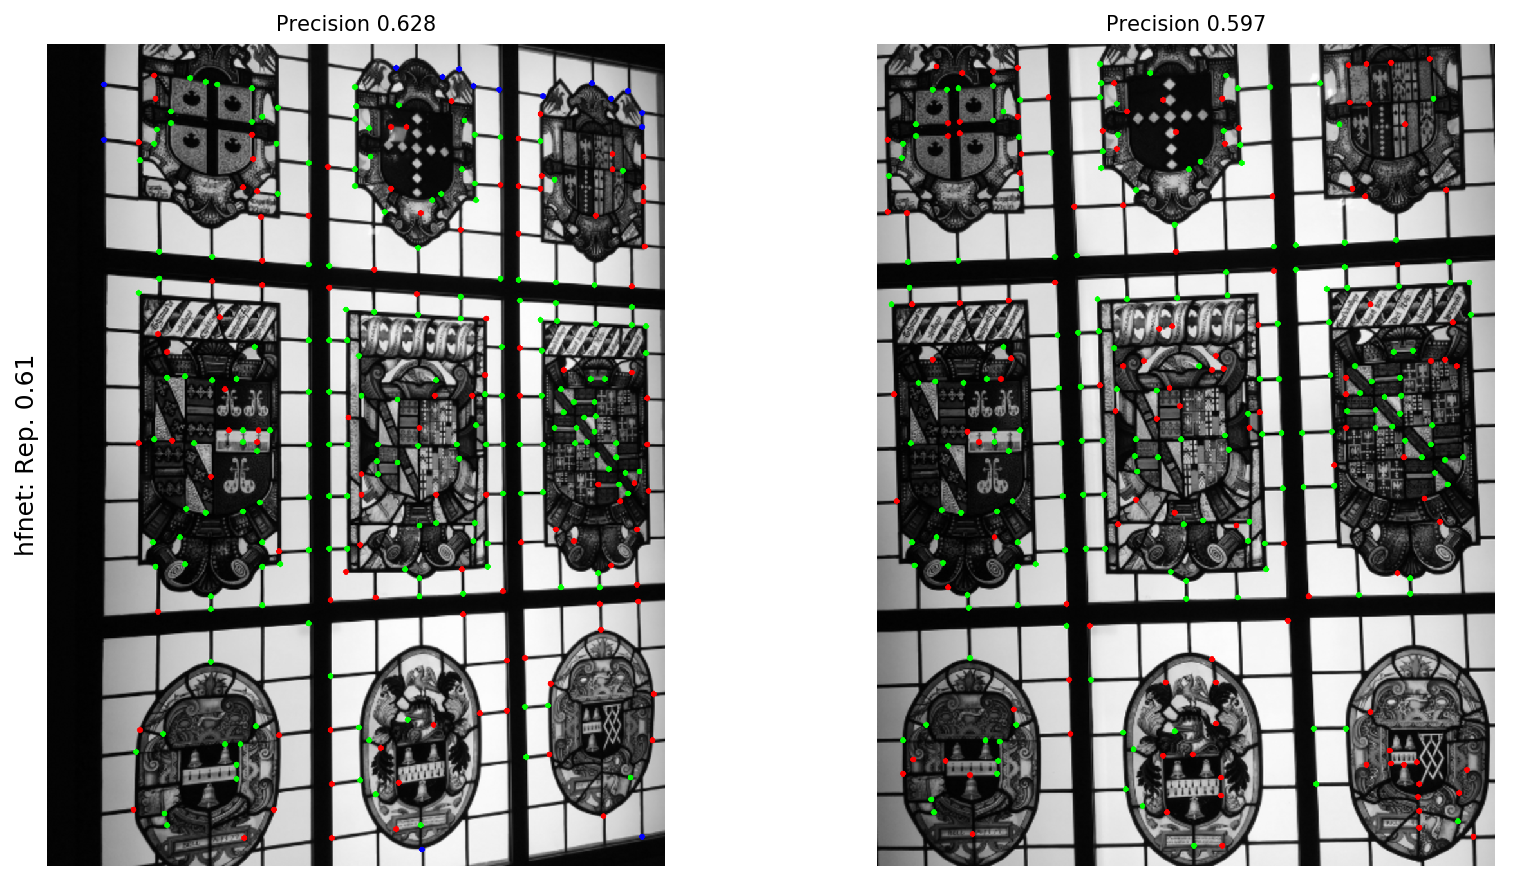

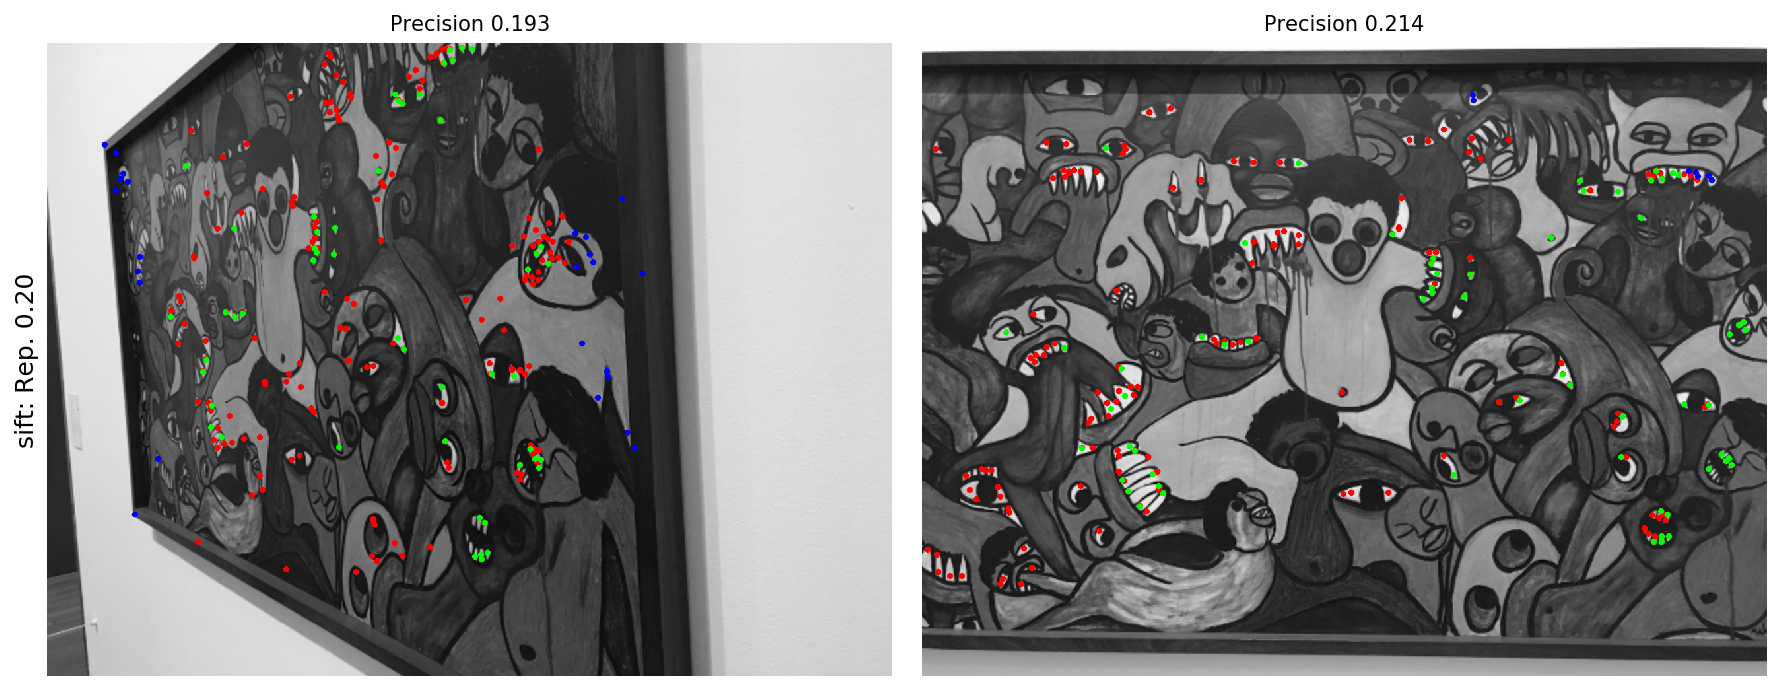

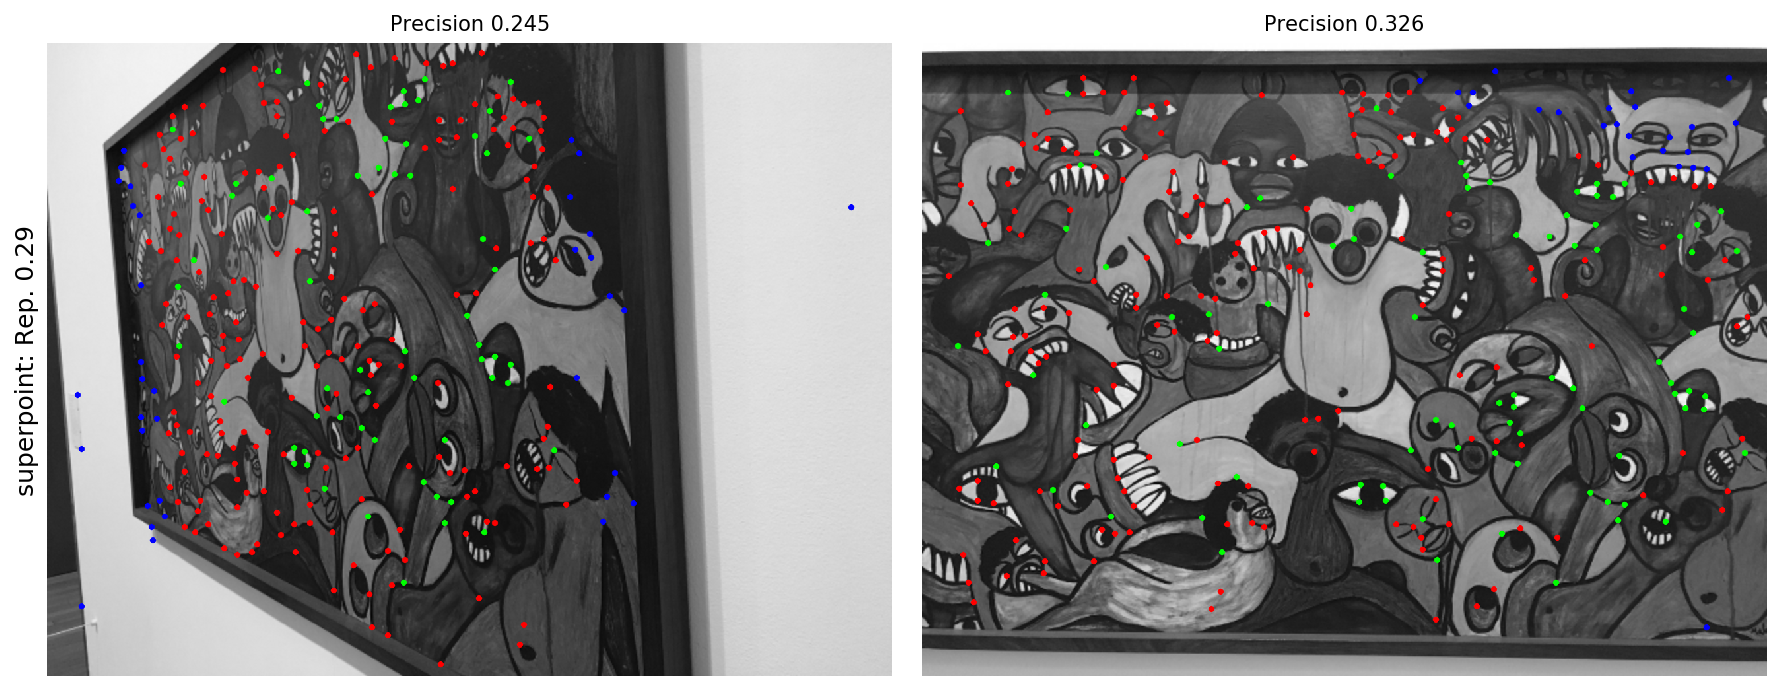

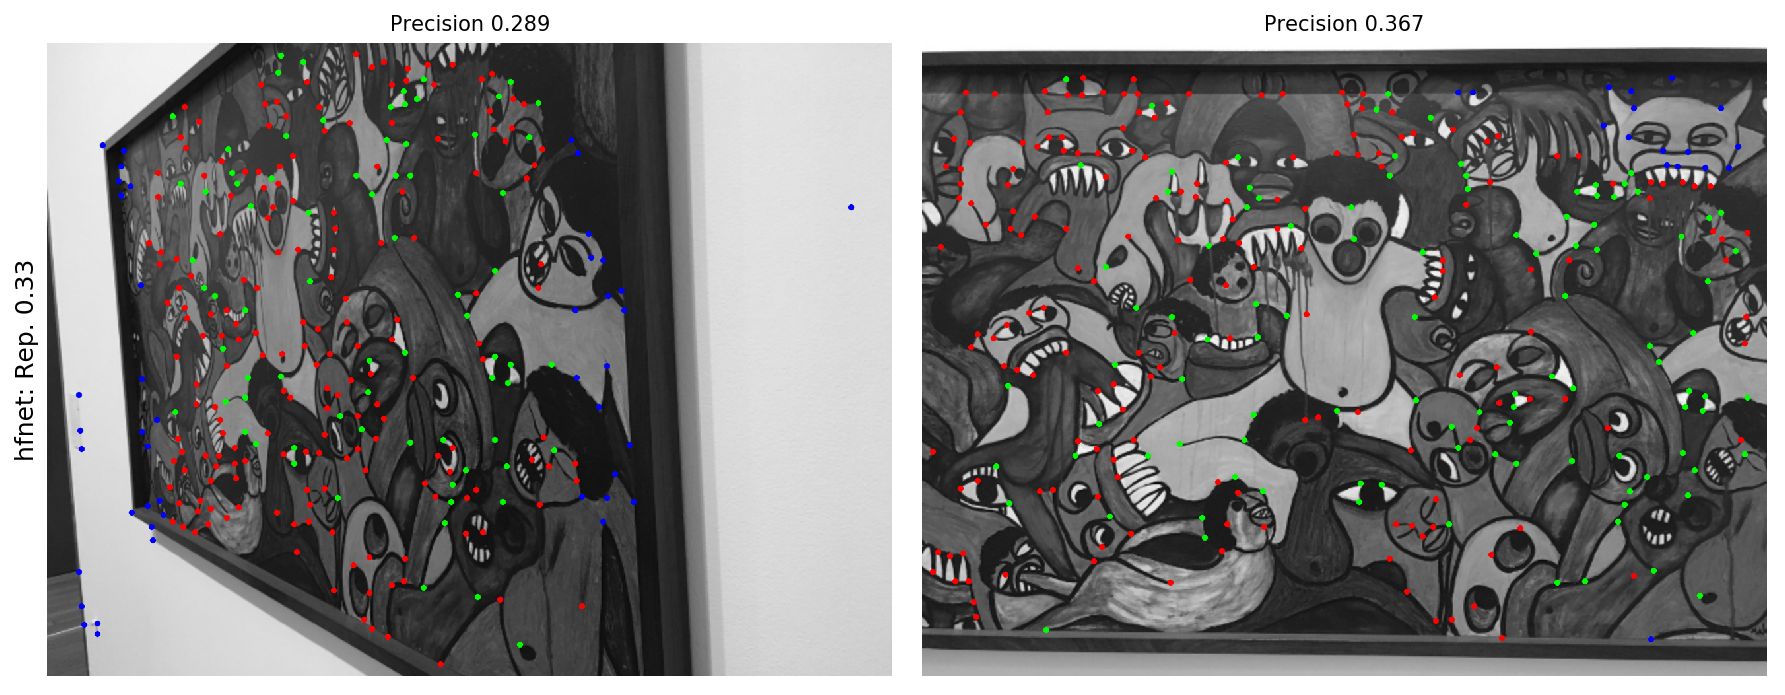

In [8]:
data_iter = dataset.get_test_set()
for _, data in zip(range(2), data_iter):
    for method, config in configs.items():
        pred1 = config['predictor'](data['image'], data['name'], **config)
        pred2 = config['predictor'](data['image2'], data['name2'], **config)
        
        kpts1_w, vis1 = keypoints_warp_2D(
            pred1['keypoints'], np.linalg.inv(data['homography']), data['image2'].shape[1::-1])
        kpts2_w, vis2 = keypoints_warp_2D(
            pred2['keypoints'], data['homography'], data['image'].shape[1::-1])
        correct1, correct2, dist1, dist2 = compute_correctness(
            pred1['keypoints'], pred2['keypoints'], kpts1_w, kpts2_w, 3, mutual=True)
        rep = (correct1[vis1].sum() + correct2[vis2].sum()) / (vis1.sum() + vis2.sum())
        
        im1 = data['image'].astype(np.uint8).copy()
        im1 = draw_keypoints(im1, pred1['keypoints'][vis1&(~correct1)], s=2, radius=4, color=(0,0,255))
        im1 = draw_keypoints(im1, pred1['keypoints'][vis1&correct1]*2, s=1, radius=4)
        im1 = draw_keypoints(im1, pred1['keypoints'][~vis1]*2, s=1, radius=4, color=(255,0,0))
        
        im2 = data['image2'].astype(np.uint8).copy()
        im2 = draw_keypoints(im2, pred2['keypoints'][vis2&(~correct2)], s=2, radius=4, color=(0,0,255))        
        im2 = draw_keypoints(im2, pred2['keypoints'][vis2&correct2]*2, s=1, radius=4)
        im2 = draw_keypoints(im2, pred2['keypoints'][~vis2]*2, s=1, radius=4, color=(255,0,0))
        
        plot_images(
            [im1, im2], ylabel=f'{method}: Rep. {rep:.2f}', labelfont=12, dpi=150,
            titles=[f'Precision {correct1[vis1].mean():.3f}', f'Precision {correct2[vis2].mean():.3f}'],
        )